In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

from utils import *

%load_ext autoreload
%autoreload 2


# load in 

In [2]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "hospital_ownership",
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "socioeconomic_status_sum",
    "hh_characteristics_sum",
    "minority_status_sum",
    "housing_status_sum",
    "series_themes_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
    "number_of_readmissions",
    "number_of_discharges",
    "condition_name",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# drop nans & rows with -999 (the nan equivalent in the sdoh data)
df.dropna(inplace=True)
df = df[df != -999].dropna()

# remaking readmission rate because it was an int, should be a float w/ decimals
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(columns=["number_of_readmissions", "number_of_discharges"], inplace=True)

## Numeric Variables

In [3]:
## Make df with X,y
model_name = "linear_numeric"
# filter df to only numeric columns
numeric_only = df.select_dtypes(include=["float64"])

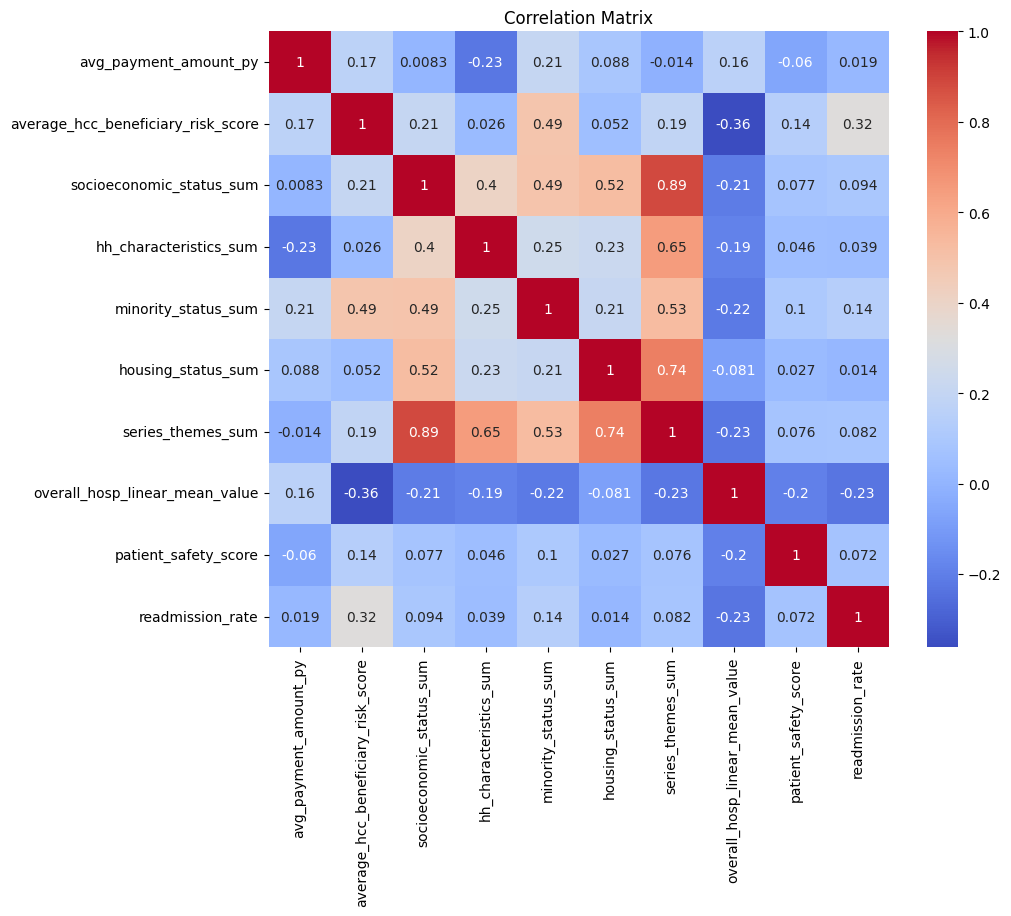

In [4]:
# Assuming your DataFrame is called 'data'
correlation_matrix = numeric_only.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Colinearity 

In [5]:
X = numeric_only.drop(columns=["readmission_rate"])
X = sm.add_constant(X)  # Add a constant column for the intercept

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [
    np.inf
    if col != "const" and (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared) == 0
    else 1 / (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared)
    for col in X.columns
]

print(vif)

                              Feature          VIF
0                               const  1451.724570
1               avg_payment_amount_py     1.222350
2  average_hcc_beneficiary_risk_score     1.513459
3            socioeconomic_status_sum          inf
4              hh_characteristics_sum          inf
5                 minority_status_sum          inf
6                  housing_status_sum          inf
7                   series_themes_sum          inf
8      overall_hosp_linear_mean_value     1.285343
9                patient_safety_score     1.051389


In [6]:
X = numeric_only.drop(columns=["readmission_rate", "series_themes_sum"])
X = sm.add_constant(X)  # Add a constant column for the intercept

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [
    np.inf
    if col != "const" and (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared) == 0
    else 1 / (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared)
    for col in X.columns
]

vif

,Feature,VIF
0,const,1451.724570
1,avg_payment_amount_py,1.222350
2,average_hcc_beneficiary_risk_score,1.513459
3,socioeconomic_status_sum,1.927998
4,hh_characteristics_sum,1.322116
5,minority_status_sum,1.767306
6,housing_status_sum,1.413712
7,overall_hosp_linear_mean_value,1.285343
8,patient_safety_score,1.051389


### Linear Model w/ only numeric variables

In [7]:
numeric_only.drop(
    columns=["series_themes_sum"], inplace=True
)  # this is a aggregate not a feature

In [8]:
## --- Create design matrix, standardize & train/test split
X = numeric_only.drop("readmission_rate", axis=1)
y = numeric_only["readmission_rate"]

# Create a new DataFrame with the standardized numerical features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

### --- fit
fit_model, summary_table = fit_linear_model(
    X_scaled, y, model_name, group=1, sdoh=True, summary_table=None
)
summary_table

linear_numeric mse: 17.881, r2: 0.08


,model_name,group,w_sdoh,r2,mse,feature_names
0,linear_numeric,1,True,0.081322,17.880747,"avg_payment_amount_py, average_hcc_beneficiary..."


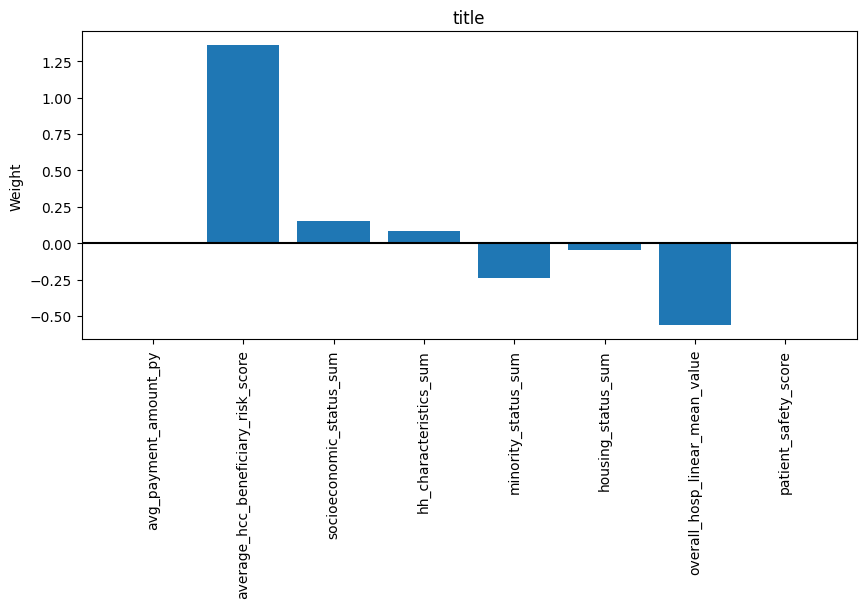

In [9]:
plot_linear_weights(X, fit_model)

### Linear model w/ only numeric & no SDOH vars

In [10]:
## Make df with X,y---
model_name = "numeric_only_no_sdoh"
numeric_only_no_sdoh = numeric_only.filter(regex="^(?!.*sum).*$")

## create design matrix, standardize & train/test split--
X = numeric_only_no_sdoh.drop("readmission_rate", axis=1)
y = numeric_only_no_sdoh["readmission_rate"]

# Standardize and center the features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

fit_model, summary_table = fit_linear_model(
    X_scaled, y, model_name, group=1, sdoh=False, summary_table=summary_table
)
summary_table

numeric_only_no_sdoh mse: 17.849, r2: 0.08


,model_name,group,w_sdoh,r2,mse,feature_names
0,linear_numeric,1,True,0.081322,17.880747,"avg_payment_amount_py, average_hcc_beneficiary..."
1,numeric_only_no_sdoh,1,False,0.082968,17.848710,"avg_payment_amount_py, average_hcc_beneficiary..."


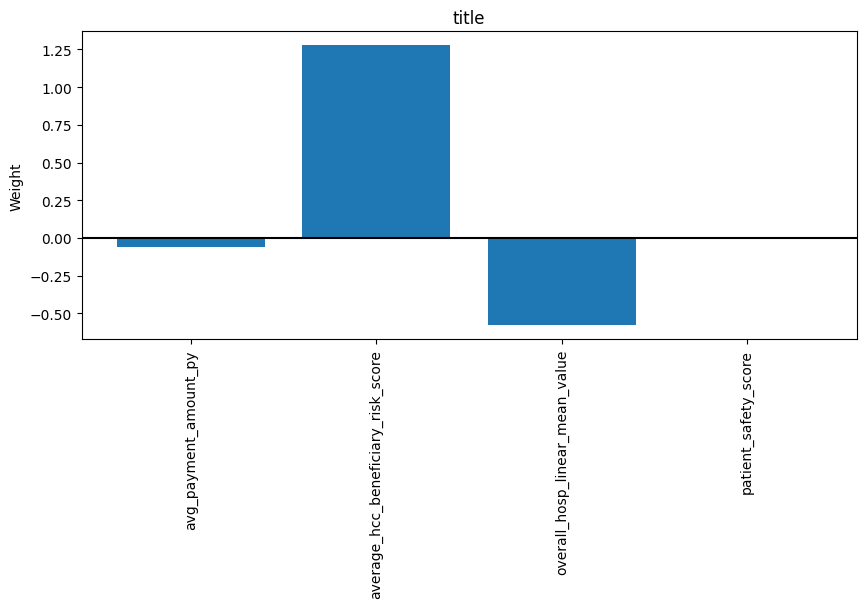

In [11]:
plot_linear_weights(X, fit_model)

### Linear model w/ only numeric + aggregate sdoh

In [12]:
## Make df with X,y
model_name = "linear_numeric_sdoh_agg"
# filter df to only numeric columns
numeric_only = df.select_dtypes(include=["float64"])
numeric_only_sdoh_agg = numeric_only.drop(
    columns=[
        "hh_characteristics_sum",
        "minority_status_sum",
        "socioeconomic_status_sum",
        "housing_status_sum",
    ],
)

## create design matrix, standardize & train/test split--
X = numeric_only_sdoh_agg.drop("readmission_rate", axis=1)
y = numeric_only_sdoh_agg["readmission_rate"]

# Standardize and center the features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

## Fit model---
fit_model, summary_table = fit_linear_model(
    X_scaled, y, model_name, group=1, sdoh=True, summary_table=summary_table
)
summary_table

linear_numeric_sdoh_agg mse: 17.869, r2: 0.08


,model_name,group,w_sdoh,r2,mse,feature_names
0,linear_numeric,1,True,0.081322,17.880747,"avg_payment_amount_py, average_hcc_beneficiary..."
1,numeric_only_no_sdoh,1,False,0.082968,17.848710,"avg_payment_amount_py, average_hcc_beneficiary..."
2,linear_numeric_sdoh_agg,1,True,0.081943,17.868660,"avg_payment_amount_py, average_hcc_beneficiary..."


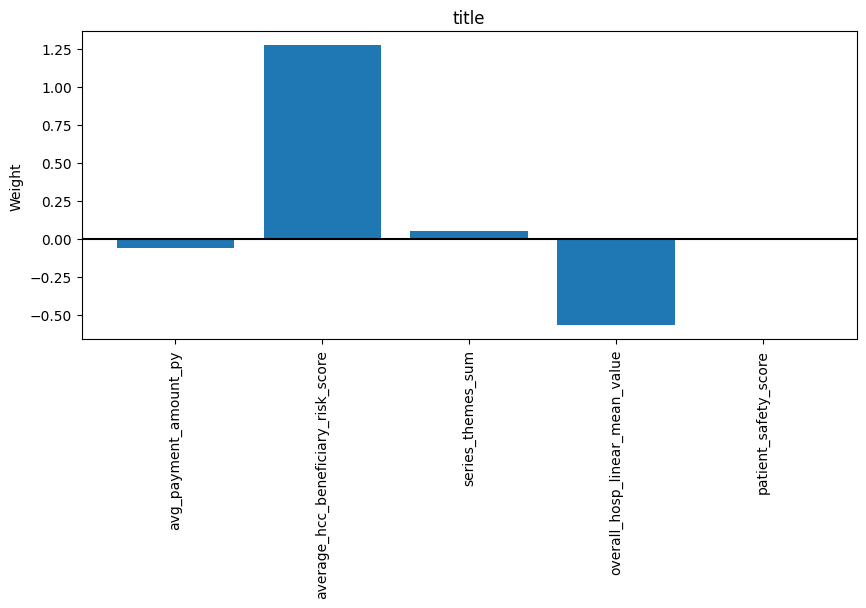

In [13]:
plot_linear_weights(X, fit_model)

#### Numeric only conclusion

Based on the fits above, we aren't able to predict readmission rates very well and removing the sdoh variable(s) doesn't affect things. Moreover, although the minority status variable does seem to have a larger weight- when the aggregate sdoh metric is used in place of the subs, the model performance does not change. Lets see if we can get any improvement using categorical vars.

### Numeric columns + condition type
#### w/ SODH

In [14]:
model_name = "cat_condition_only"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "socioeconomic_status_sum",
    "hh_characteristics_sum",
    "minority_status_sum",
    "housing_status_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
]
cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=2, sdoh=True, summary_table=None
)
summary_table

cat_condition_only mse: 14.379, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."


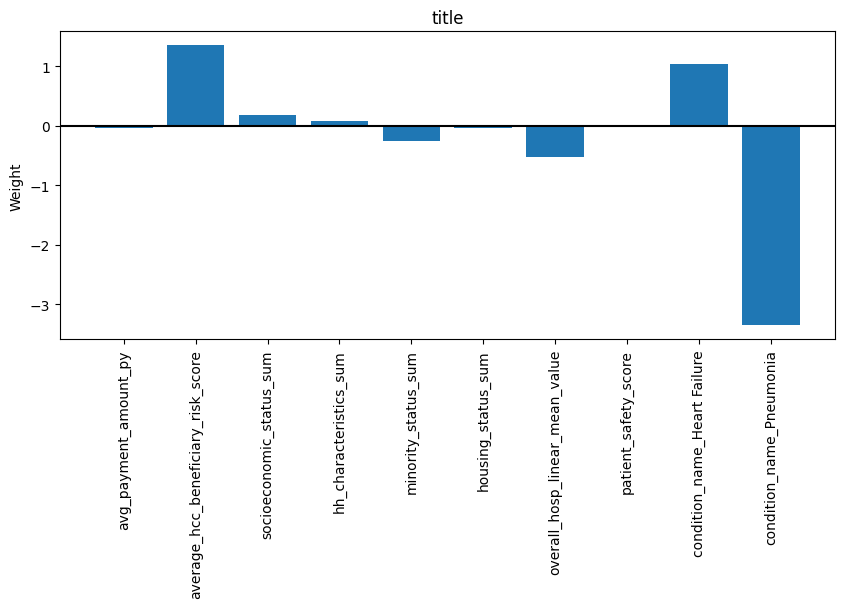

In [15]:
plot_linear_weights(X_processed, fit_model)

#### w/o SDOH

cat_condition_only_no_sdoh mse: 14.328, r2: 0.26


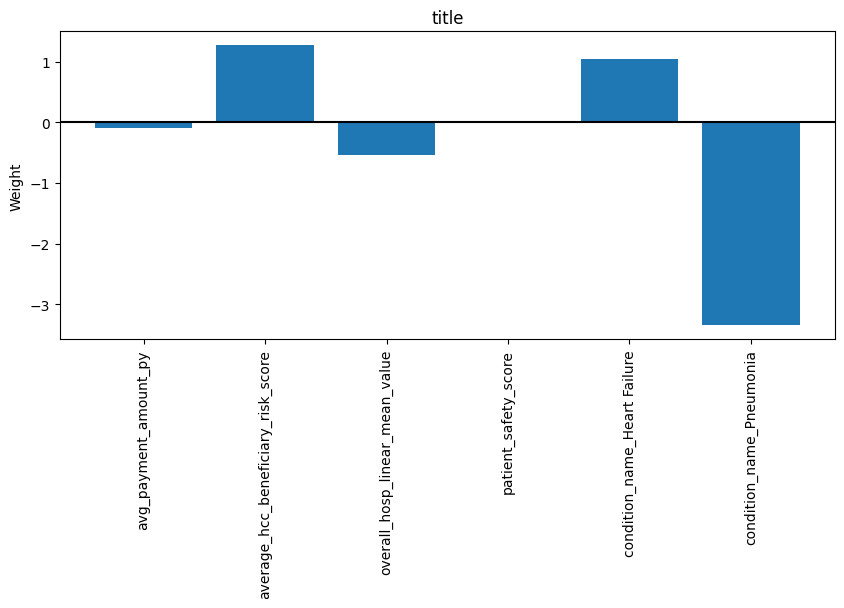

In [16]:
model_name = "cat_condition_only_no_sdoh"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
]
cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=2, sdoh=False, summary_table=summary_table
)
summary_table
plot_linear_weights(X_processed, fit_model)

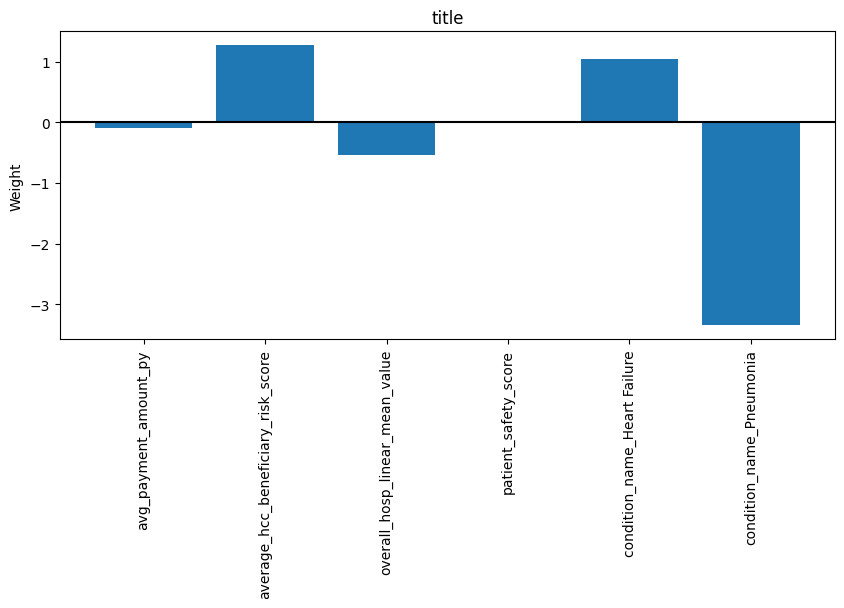

In [17]:
plot_linear_weights(X_processed, fit_model)

#### w/ SDOH agg


In [18]:
model_name = "cat_condition_only_agg_sdoh"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
    "series_themes_sum",
]
cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=2, sdoh=True, summary_table=summary_table
)
summary_table

cat_condition_only_agg_sdoh mse: 14.363, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."


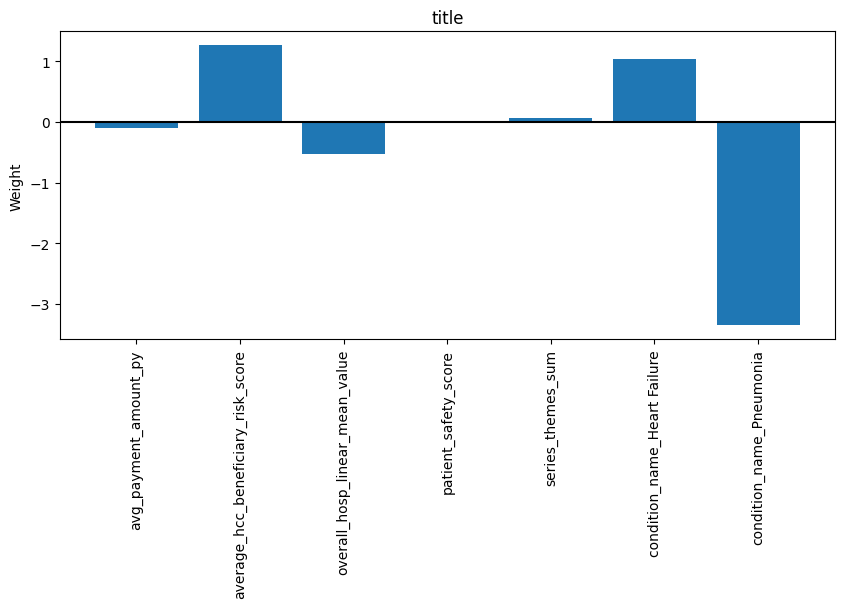

In [19]:
plot_linear_weights(X_processed, fit_model)

### All columns of interest 

#### w SDOH sub aggs

In [20]:
model_name = "init_colsofinterest"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "socioeconomic_status_sum",
    "hh_characteristics_sum",
    "minority_status_sum",
    "housing_status_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
]

cat_cols = ["hospital_ownership", "condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=3, sdoh=True, summary_table=summary_table
)
summary_table

init_colsofinterest mse: 14.36, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."


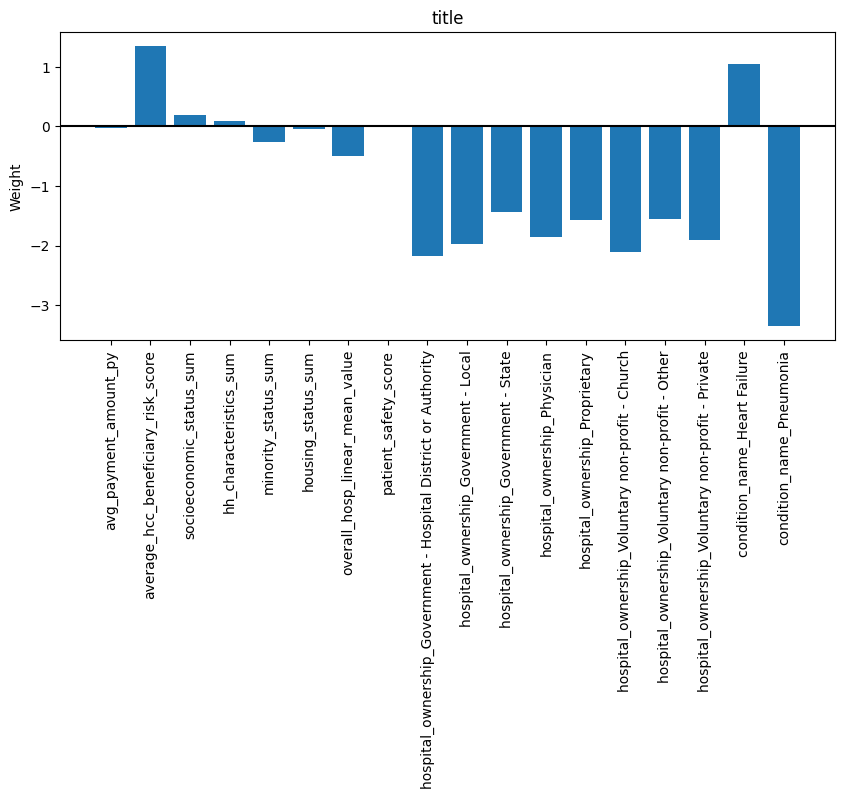

In [21]:
plot_linear_weights(X_processed, fit_model)

#### w/ SDOH agg

In [22]:
model_name = "init_colsofinterest_aggsdoh"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "series_themes_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
]

cat_cols = ["hospital_ownership", "condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=3, sdoh=True, summary_table=summary_table
)
summary_table

init_colsofinterest_aggsdoh mse: 14.341, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."
4,init_colsofinterest_aggsdoh,3,True,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."


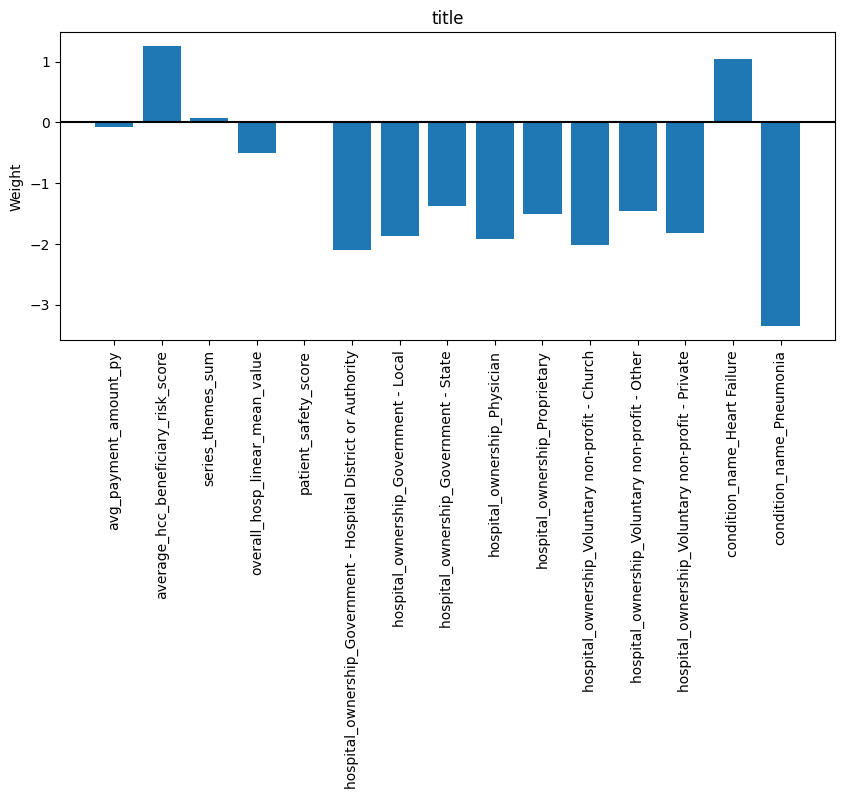

In [23]:
plot_linear_weights(X_processed, fit_model)

#### w/o SDOH


In [24]:
model_name = "init_colsofinterest_nosdoh"

numeric_cols = [
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "series_themes_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
]

cat_cols = ["hospital_ownership", "condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=3, sdoh=False, summary_table=summary_table
)
summary_table

init_colsofinterest_nosdoh mse: 14.341, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."
4,init_colsofinterest_aggsdoh,3,True,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
5,init_colsofinterest_nosdoh,3,False,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."


#### Best fitting cols

It seems like payment rate and safety score consistently have weights close to 0, so let's remove them. Also, The hospital type might be a better categorical variable if aggregated into fewer categories, all of the weights are negative so it's not very interpretable. 


In [25]:
model_name = "best_fit_cols"

numeric_cols = [
    "average_hcc_beneficiary_risk_score",
    "socioeconomic_status_sum",
    "hh_characteristics_sum",
    "minority_status_sum",
    "housing_status_sum",
    "overall_hosp_linear_mean_value",
]

cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=4, sdoh=True, summary_table=summary_table
)
summary_table

best_fit_cols mse: 14.367, r2: 0.26


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."
4,init_colsofinterest_aggsdoh,3,True,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
5,init_colsofinterest_nosdoh,3,False,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
6,best_fit_cols,4,True,0.261874,14.366562,"average_hcc_beneficiary_risk_score, socioecono..."


Text(0.5, 1.0, 'Hospital + SDOH Features, $r^2$ = 0.262, mse = 14.36')

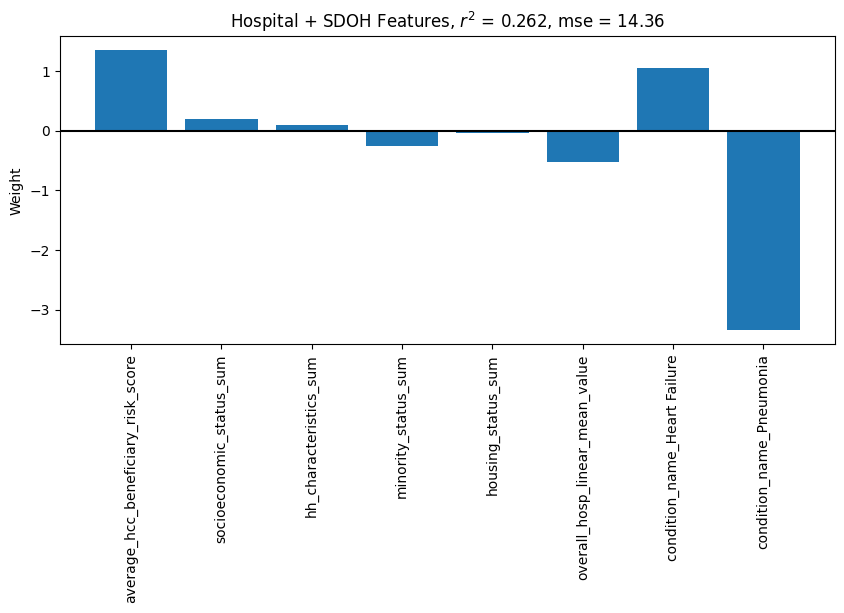

In [26]:
plot_linear_weights(X_processed, fit_model)
plt.title(f"Hospital + SDOH Features, $r^2$ = 0.262, mse = 14.36")

In [27]:
model_name = "best_fit_cols_nosdoh"

numeric_cols = [
    "average_hcc_beneficiary_risk_score",
    "overall_hosp_linear_mean_value",
]

cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=4, sdoh=False, summary_table=summary_table
)
summary_table

best_fit_cols_nosdoh mse: 14.291, r2: 0.27


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."
4,init_colsofinterest_aggsdoh,3,True,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
5,init_colsofinterest_nosdoh,3,False,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
6,best_fit_cols,4,True,0.261874,14.366562,"average_hcc_beneficiary_risk_score, socioecono..."
7,best_fit_cols_nosdoh,4,False,0.265761,14.290903,"average_hcc_beneficiary_risk_score, overall_ho..."


Text(0.5, 1.0, 'Hospital only Features, $r^2$ = 0.265, mse = 14.29')

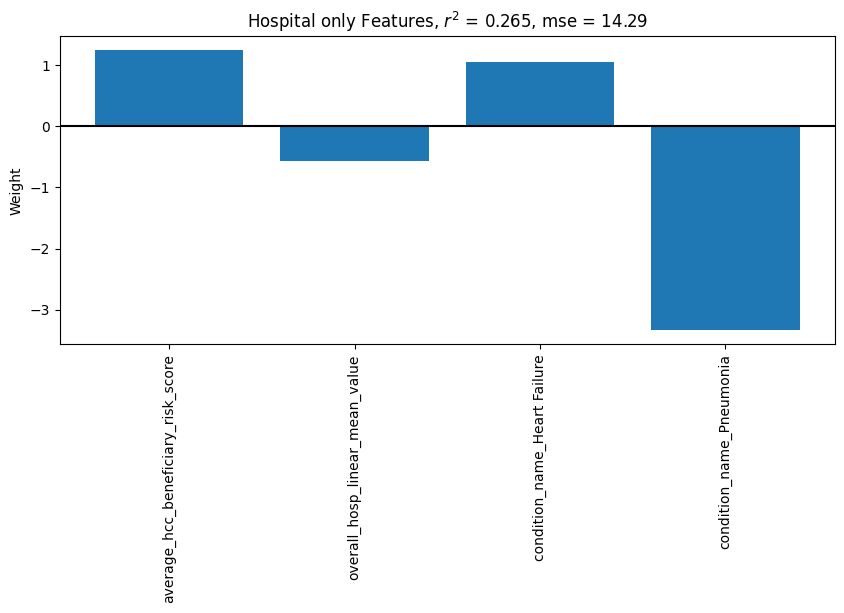

In [28]:
plot_linear_weights(X_processed, fit_model)
plt.title(f"Hospital only Features, $r^2$ = 0.265, mse = 14.29")

In [29]:
model_name = "best_fit_cols_minority_only"

numeric_cols = [
    "average_hcc_beneficiary_risk_score",
    "minority_status_sum",
    "overall_hosp_linear_mean_value",
]

cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols, cat_cols)
y = df["readmission_rate"]

fit_model, summary_table = fit_linear_model(
    X_processed, y, model_name, group=4, sdoh=True, summary_table=summary_table
)
summary_table

best_fit_cols_minority_only mse: 14.295, r2: 0.27


,model_name,group,w_sdoh,r2,mse,feature_names
0,cat_condition_only,2,True,0.261229,14.379121,"avg_payment_amount_py, average_hcc_beneficiary..."
1,cat_condition_only_no_sdoh,2,False,0.263858,14.327947,"avg_payment_amount_py, average_hcc_beneficiary..."
2,cat_condition_only_agg_sdoh,2,True,0.262048,14.363172,"avg_payment_amount_py, average_hcc_beneficiary..."
3,init_colsofinterest,3,True,0.262207,14.360078,"avg_payment_amount_py, average_hcc_beneficiary..."
4,init_colsofinterest_aggsdoh,3,True,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
5,init_colsofinterest_nosdoh,3,False,0.263165,14.341440,"avg_payment_amount_py, average_hcc_beneficiary..."
6,best_fit_cols,4,True,0.261874,14.366562,"average_hcc_beneficiary_risk_score, socioecono..."
7,best_fit_cols_nosdoh,4,False,0.265761,14.290903,"average_hcc_beneficiary_risk_score, overall_ho..."
8,best_fit_cols_minority_only,4,True,0.265559,14.294850,"average_hcc_beneficiary_risk_score, minority_s..."


#### Summary

(0.2, 0.3)

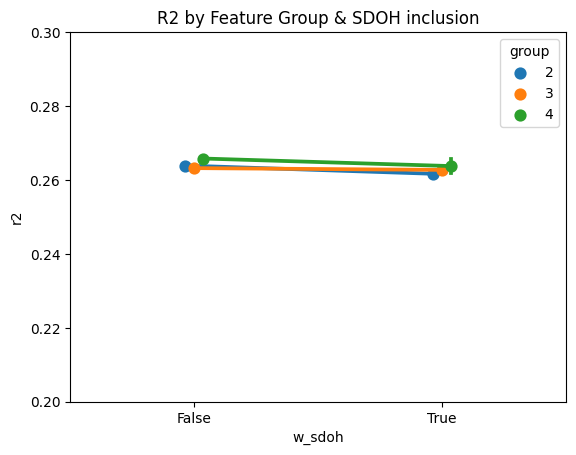

In [30]:
sns.pointplot(data=summary_table, x="w_sdoh", y="r2", hue="group", dodge=True)

plt.title("R2 by Feature Group & SDOH inclusion")
plt.ylim(0.2, 0.30)

(14.0, 15.0)

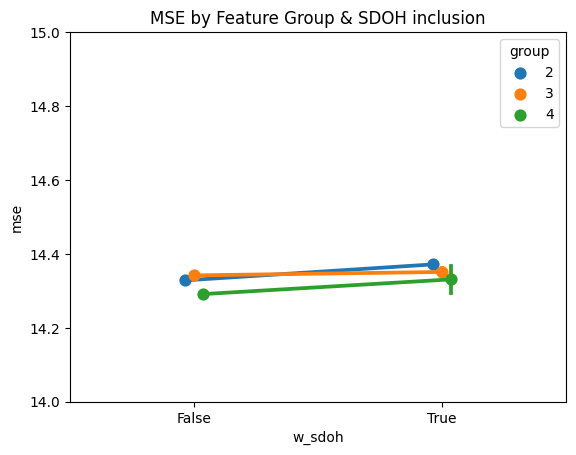

In [31]:
sns.pointplot(data=summary_table, x="w_sdoh", y="mse", hue="group", dodge=True)

plt.title("MSE by Feature Group & SDOH inclusion")
plt.ylim(14, 15)